INTRODUCTION 
On the basis of music service database (Chinook.db) I try to demonstrate the appliance of SQL for business recomendations. Scheme of the database may be found here:https://s3.amazonaws.com/dq-content/191/chinook-schema.svg


In [ ]:
SUPPORT FUNCTIONS

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


QUESTION # 1: TOP SELLING GENRES
In order to give recomendation to management regarding development strategy (for instance, which new artist needs active promotion), we will define top selling genres in particular country. It is reasonable to use United States as an example since it is the biggest market for music industry. 

In [2]:
genres_usa = '''
WITH invoices_usa AS
(SELECT i.invoice_id,
        il.track_id
        FROM invoice i
INNER JOIN invoice_line il ON il.invoice_id=i.invoice_id
WHERE i.billing_country='USA'),
tracks_by_genre AS
(SELECT t.track_id,
        g.name genres
        FROM track t
INNER JOIN genre g ON g.genre_id=t.genre_id)
SELECT tbg.genres,
       COUNT(ius.invoice_id) tracks_sold_USA,
       (100*CAST(COUNT(ius.invoice_id) as float)/
       (SELECT COUNT(track_id) FROM invoices_usa)) percentage
       FROM tracks_by_genre tbg
INNER JOIN invoices_usa ius ON ius.track_id=tbg.track_id
GROUP BY 1
ORDER BY 2 DESC
'''
run_query(genres_usa)


,genres,tracks_sold_USA,percentage
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


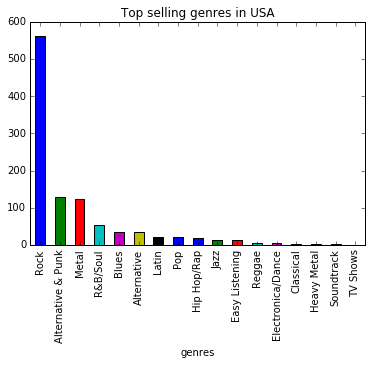

In [3]:
genres_usa=run_query(genres_usa)
genres_usa.set_index("genres", inplace=True, drop=True)
genres_usa['tracks_sold_USA'].plot.bar(title='Top selling genres in USA',ylim=(0,600))
plt.show()

RECOMENDATION # 1:  
The plot and the table above show that Rock is the absolute leader among music genres in US. The management must pay attention to new artist in this genre as well as Punk and Metal. At that total share of Pop and Hip-Hop (about 4%) is surprisingly small, so investment in new artists in these genres are not so obvious.     

QUESTIONS # 2: TOP SELLING MANAGERS
Management asked to analyse perfomance of sales managers. 

In [4]:
sales_by_agent = '''WITH spend_by_customer AS
(SELECT c.customer_id,
        SUM (i.total) total_sales
 FROM customer c
INNER JOIN invoice i ON i.customer_id=c.customer_id
GROUP BY 1),

customers_by_agents AS
(SELECT e.first_name || " " || e.last_name agent,
        c.customer_id,
        e.hire_date,
        e.country,
        e.city,
        e.birthdate
        FROM employee e
INNER JOIN customer c ON c.support_rep_id=e.employee_id 
WHERE e.title='Sales Support Agent')

SELECT sbs.agent,
       SUM(sbc.total_sales) total,
       sbs.hire_date,
       sbs.birthdate
FROM spend_by_customer sbc
INNER JOIN customers_by_agents sbs ON sbs.customer_id=sbc.customer_id
GROUP BY 1
ORDER BY 2 DESC'''
run_query(sales_by_agent)


,agent,total,hire_date,birthdate
0,Jane Peacock,1731.51,2017-04-01 00:00:00,1973-08-29 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00,1947-09-19 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00,1965-03-03 00:00:00


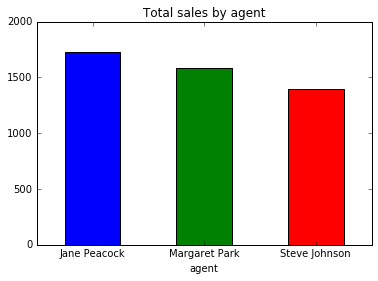

In [5]:
sales_by_agent=run_query(sales_by_agent)
sales_by_agent.set_index("agent", inplace=True, drop=True)
sales_by_agent['total'].plot.bar(title='Total sales by agent',ylim=(0,2000),rot=0)
plt.show()

RECOMENDATION # 2:
Jane Peacock is the most efficient sales agent with approximately 20% advantage in front of the worst one. Her perfomance may have correlations with her age and hire date.

QUESTION # 3:
Management asks to analyse the data for customers form each different country and give some general recomendations on which countries have potential for growth. 

In [6]:
country_data = '''
WITH 
customers_per_country AS 
(SELECT c.country,
       COUNT (c.customer_id) number_of_customers
FROM customer c
GROUP BY 1
ORDER BY 2 DESC),

sales_per_country AS 
(SELECT c.country,
        SUM (i.total) total_sales,
        COUNT(i.invoice_id) number_of_invoices
FROM customer c
INNER JOIN invoice i ON i.customer_id=c.customer_id
GROUP BY 1)
SELECT cpc.country,
       cpc.number_of_customers,
       spc.total_sales,
       ROUND(
       (spc.total_sales/cpc.number_of_customers)) avg_value,
       ROUND (
       (spc.total_sales/spc.number_of_invoices),2) avg_invoice
FROM customers_per_country cpc
INNER JOIN sales_per_country spc ON spc.country=cpc.country

GROUP BY 1
ORDER BY 2 DESC'''

run_query(country_data)

,country,number_of_customers,total_sales,avg_value,avg_invoice
0,USA,13,1040.49,80.0,7.94
1,Canada,8,535.59,67.0,7.05
2,Brazil,5,427.68,86.0,7.01
3,France,5,389.07,78.0,7.78
4,Germany,4,334.62,84.0,8.16
5,United Kingdom,3,245.52,82.0,8.77
6,Czech Republic,2,273.24,137.0,9.11
7,India,2,183.15,92.0,8.72
8,Portugal,2,185.13,93.0,6.38
9,Argentina,1,39.60,40.0,7.92


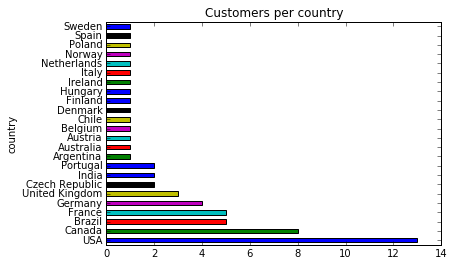

In [7]:
country_data=run_query(country_data)
country_data.set_index("country", inplace=True, drop=True)
country_data['number_of_customers'].plot.barh(title='Customers per country',ylim=(0,15),rot=0)
plt.show()

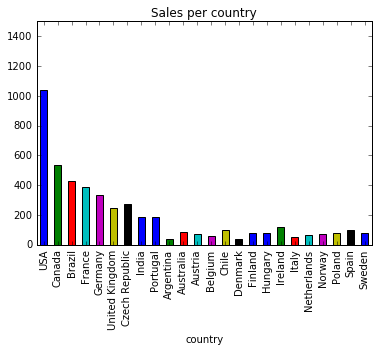

In [8]:

country_data['total_sales'].plot.bar(title='Sales per country',ylim=(0,1500))
plt.show()

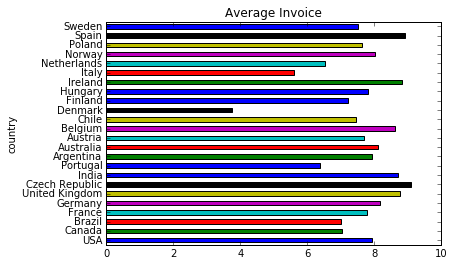

In [9]:

country_data['avg_invoice'].plot.barh(title='Average Invoice',ylim=(0,10),rot=0)
plt.show()

RECOMENDATION # 3: 
Such countries as Brazil, France, Germany, the UK, Czech Republic has substantial potential for growth. It would be resonable to start marketing campaigns on this market, but due to limited number of acting customers marketing activities have to be pinponted.  

QUESTION # 4:
Company considers to allow customers to purchase only the most popular tracks from each album, instead of purchasing every track from an album. We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [10]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


RECOMENDATION # 4:
Based on our analysis, we would not recommend purchasing only selected tracks from albums, since there is a risk to lose significant part of net sales.